In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from math import * # module math
import matplotlib.pyplot as plt # visualization
from PIL import Image
import seaborn as sns # visualization
import itertools
import io
import plotly.offline as py # visualization
py.init_notebook_mode(connected=True) # visualization
import plotly.graph_objs as go # visualization
from plotly.subplots import make_subplots
import plotly.figure_factory as ff # visualization
import warnings
warnings.filterwarnings("ignore")

In [3]:
telcom = pd.read_csv(r"/home/amr/Downloads/maryam/churn-bigml-80.csv")
telcom_test = pd.read_csv(r"/home/amr/Downloads/maryam/churn-bigml-20.csv")
telcom.head()


,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [4]:
def dataoveriew(df, message):
    print(f'{message}:\n')
    print("Rows:", df.shape[0])
    print("\nNumber of features:", df.shape[1])
    print("\nFeatures:")
    print(telcom.columns.tolist())
    print("\nMissing values:", df.isnull().sum().values.sum())
    print("\nUnique values:")
    print(df.nunique())

In [5]:
dataoveriew(telcom, 'Overiew of the training dataset')

Overiew of the training dataset:

Rows: 2666

Number of features: 20

Features:
['State', 'Account length', 'Area code', 'International plan', 'Voice mail plan', 'Number vmail messages', 'Total day minutes', 'Total day calls', 'Total day charge', 'Total eve minutes', 'Total eve calls', 'Total eve charge', 'Total night minutes', 'Total night calls', 'Total night charge', 'Total intl minutes', 'Total intl calls', 'Total intl charge', 'Customer service calls', 'Churn']

Missing values: 0

Unique values:
State                       51
Account length             205
Area code                    3
International plan           2
Voice mail plan              2
Number vmail messages       42
Total day minutes         1489
Total day calls            115
Total day charge          1489
Total eve minutes         1442
Total eve calls            120
Total eve charge          1301
Total night minutes       1444
Total night calls          118
Total night charge         885
Total intl minutes         15

In [6]:
dataoveriew(telcom_test, 'Overiew of the test dataset')


Overiew of the test dataset:

Rows: 667

Number of features: 20

Features:
['State', 'Account length', 'Area code', 'International plan', 'Voice mail plan', 'Number vmail messages', 'Total day minutes', 'Total day calls', 'Total day charge', 'Total eve minutes', 'Total eve calls', 'Total eve charge', 'Total night minutes', 'Total night calls', 'Total night charge', 'Total intl minutes', 'Total intl calls', 'Total intl charge', 'Customer service calls', 'Churn']

Missing values: 0

Unique values:
State                      51
Account length            179
Area code                   3
International plan          2
Voice mail plan             2
Number vmail messages      37
Total day minutes         562
Total day calls           100
Total day charge          562
Total eve minutes         557
Total eve calls            94
Total eve charge          528
Total night minutes       568
Total night calls          96
Total night charge        453
Total intl minutes        132
Total intl calls   

In [7]:
trace = go.Pie(labels = telcom["Churn"].value_counts().keys().tolist(),
               values = telcom["Churn"].value_counts().values.tolist(),
               marker = dict(colors = ['royalblue','lime'],
                             line = dict(color = "white", width =  1.3)
                            ),
               rotation = 90,
               hoverinfo = "label+value+text",
               hole = .5
              )
layout = go.Layout(dict(title = "Customer churn in training data",
                        plot_bgcolor = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                       )
                  )
data = [trace]
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#Removing correlated and unneccessary columns
col_to_drop = ['State', 'Area code', 'Total day charge', 'Total eve charge', 
               'Total night charge', 'Total intl charge']
   
telcom = telcom.drop(columns = col_to_drop, axis = 1)
telcom_test = telcom_test.drop(columns = col_to_drop, axis = 1)

#target column
target_col = ["Churn"]

#number of levels in feature to be a categorical feature
nlevels = 6

#Separating categorical and numerical columns
#categorical columns
cat_cols = list(set(telcom.nunique()[telcom.nunique()<nlevels].keys().tolist() 
                    + telcom.select_dtypes(include='object').columns.tolist()))
cat_cols = [x for x in cat_cols if x not in target_col]
#numerical columns
num_cols = [x for x in telcom.columns if x not in cat_cols + target_col]
#Binary columns with 2 values
bin_cols = telcom.nunique()[telcom.nunique() == 2].keys().tolist()
#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

#Label encoding Binary columns
le = LabelEncoder()
for i in bin_cols:
    telcom[i] = le.fit_transform(telcom[i])
    telcom_test[i] = le.transform(telcom_test[i])

#combining the train and test datasets
trainsize = telcom.shape[0]
comb = pd.concat((telcom, telcom_test), sort=False)

#Duplicating columns for multi value columns
comb = pd.get_dummies(data = comb, columns = multi_cols)

#Separating the train and test datasets
telcom = comb[:trainsize]
telcom_test = comb[trainsize:]

#Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(telcom[num_cols])
scaled = pd.DataFrame(scaled, columns=num_cols)

scaled_test = std.transform(telcom_test[num_cols])
scaled_test = pd.DataFrame(scaled_test, columns=num_cols)

#dropping original values merging scaled values for numerical columns
df_telcom_og = telcom.copy()
telcom = telcom.drop(columns = num_cols, axis = 1)
telcom = telcom.merge(scaled, left_index=True, right_index=True, how = "left")

df_telcom_test_og = telcom_test.copy()
telcom_test = telcom_test.drop(columns = num_cols, axis = 1)
telcom_test = telcom_test.merge(scaled_test, left_index=True, right_index=True, how = "left")

In [9]:
#correlation
correlation = telcom.corr()
#tick labels
matrix_cols = correlation.columns.tolist()
#convert to array
corr_array = np.array(correlation)

#Plotting
trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   colorscale = "Viridis",
                   colorbar = dict(title = "Pearson Correlation coefficients", titleside = "right"),
                  )
layout = go.Layout(dict(title = "Correlation matrix",
                        autosize = False,
                        height = 720,
                        width = 800,
                        margin = dict(r = 0, l = 210, t = 25, b = 210),
                        yaxis = dict(tickfont = dict(size = 9)),
                        xaxis = dict(tickfont = dict(size = 9))
                       )
                  )
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)

X = telcom[[i for i in telcom.columns if i not in target_col]]
Y = telcom[target_col]

principal_components = pca.fit_transform(X)
pca_data = pd.DataFrame(principal_components, columns = ["PC1", "PC2"])
pca_data = pca_data.merge(Y, left_index=True, right_index=True, how="left")
pca_data["Churn"] = pca_data["Churn"].replace({1: "Churn", 0: "Not churn"})


In [14]:
#separating binary columns
bi_cs = telcom.nunique()[telcom.nunique() == 2].keys()
dat_rad = telcom[bi_cs]
bi_cs, dat_rad

(Index(['International plan', 'Voice mail plan', 'Churn'], dtype='object'),
       International plan  Voice mail plan  Churn
 0                      0                1      0
 1                      0                1      0
 2                      0                0      0
 3                      1                0      0
 4                      1                0      0
 ...                  ...              ...    ...
 2661                   0                0      0
 2662                   0                1      0
 2663                   0                0      0
 2664                   0                0      0
 2665                   0                1      0
 
 [2666 rows x 3 columns])

In [20]:
pip install yellowbrick

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 271 kB 743 kB/s 
     |████████████████████████████████| 14.9 MB 340 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.5.0 requires keras-nightly~=2.5.0.dev, which is not installed.
Note: you may need to restart the kernel to use updated packages.


In [21]:
def telecom_churn_prediction(algorithm, training_x, testing_x, training_y, testing_y, cf, threshold_plot):
    #model
    algorithm.fit(training_x, training_y)
    predictions = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
        
    print('Algorithm:', type(algorithm).__name__)
    print("\nClassification report:\n", classification_report(testing_y, predictions))
    print("Accuracy Score:", accuracy_score(testing_y, predictions))
    
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y, predictions)
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y, predictions) 
    print("Area under curve:", model_roc_auc,"\n")
    
    fpr, tpr, thresholds = roc_curve(testing_y, probabilities[:,1])
     
    #plot confusion matrix
    trace1 = go.Heatmap(z = conf_matrix,
                        x = ["Not churn", "Churn"],
                        y = ["Not churn", "Churn"],
                        showscale = False, colorscale = "Picnic",
                        name = "Confusion matrix")
    
    #plot roc curve
    trace2 = go.Scatter(x = fpr, y = tpr,
                        name = "Roc: " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'), width = 2))
    trace3 = go.Scatter(x = [0,1], y = [0,1],
                        line = dict(color = ('rgb(205, 12, 24)'), width = 2,
                        dash = 'dot'))
    
    if cf in ['coefficients', 'features']:
        if cf == 'coefficients':
            coefficients = pd.DataFrame(algorithm.coef_.ravel())
        elif cf == 'features':
            coefficients = pd.DataFrame(algorithm.feature_importances_)
        
        column_df = pd.DataFrame(training_x.columns.tolist())
        coef_sumry = (pd.merge(coefficients, column_df, left_index=True, 
                               right_index=True, how="left"))
        coef_sumry.columns = ["coefficients", "features"]
        coef_sumry = coef_sumry.sort_values(by = "coefficients", ascending=False)
        
        #plot coeffs
        trace4 = go.Bar(x = coef_sumry["features"], y = coef_sumry["coefficients"], 
                        name = "coefficients",
                        marker = dict(color = coef_sumry["coefficients"],
                                      colorscale = "Picnic",
                                      line = dict(width = .6, color = "black")
                                     )
                       )
        #subplots
        fig = make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                                subplot_titles=('Confusion matrix',
                                                'Receiver operating characteristic',
                                                'Feature importances')
                           )  
        fig.append_trace(trace1,1,1)
        fig.append_trace(trace2,1,2)
        fig.append_trace(trace3,1,2)
        fig.append_trace(trace4,2,1)
        fig['layout'].update(showlegend=False, title="Model performance",
                             autosize=False, height = 900, width = 800,
                             plot_bgcolor = 'rgba(240,240,240, 0.95)',
                             paper_bgcolor = 'rgba(240,240,240, 0.95)',
                             margin = dict(b = 195))
        fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
        fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))
        fig["layout"]["xaxis3"].update(dict(showgrid = True, tickfont = dict(size = 10), tickangle = 90))
        
    elif cf == 'None':
        #subplots
        fig = make_subplots(rows=1, cols=2,
                            subplot_titles=('Confusion matrix',
                                            'Receiver operating characteristic')
                           )
        fig.append_trace(trace1,1,1)
        fig.append_trace(trace2,1,2)
        fig.append_trace(trace3,1,2)
        fig['layout'].update(showlegend=False, title="Model performance",
                         autosize=False, height = 500, width = 800,
                         plot_bgcolor = 'rgba(240,240,240,0.95)',
                         paper_bgcolor = 'rgba(240,240,240,0.95)',
                         margin = dict(b = 195))
        fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
        fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))  
        
    py.iplot(fig)
    
    if threshold_plot == True: 
        visualizer = DiscriminationThreshold(algorithm)
        visualizer.fit(training_x,training_y)
        visualizer.poof()

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from yellowbrick.classifier import DiscriminationThreshold

import statsmodels.api as sm
#defining the studied or used independent features (columns) as well the target  
cols = [i for i in telcom.columns if i not in target_col]
target_col = ['Churn']

#splitting the principal training dataset to subtrain and subtest datasets
x_train, x_test, y_train, y_test = train_test_split(telcom[cols], telcom[target_col], 
                                                    test_size = .25, random_state = 111)

#splitting the no scaled principal training dataset to subtrain and subtest datasets
x_train_og, x_test_og, y_train_og, y_test_og = train_test_split(df_telcom_og[cols], telcom[target_col],
                                                                test_size = .25, random_state = 111)

Algorithm: LogisticRegression

Classification report:
               precision    recall  f1-score   support

           0       0.84      0.97      0.90       547
           1       0.52      0.13      0.21       120

    accuracy                           0.82       667
   macro avg       0.68      0.55      0.56       667
weighted avg       0.78      0.82      0.78       667

Accuracy Score: 0.8215892053973014
Area under curve: 0.5529555149299208 



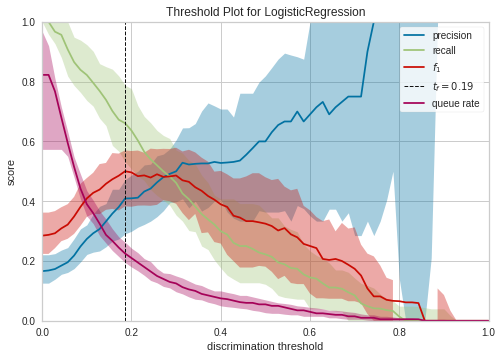

In [23]:
from sklearn.linear_model import LogisticRegression

#Baseline model        
logit = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
                           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
                           verbose=0, warm_start=False)

telecom_churn_prediction(logit, x_train, x_test, y_train, y_test, "coefficients", threshold_plot=True)

Algorithm: DecisionTreeClassifier

Classification report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94       547
           1       0.79      0.63      0.70       120

    accuracy                           0.90       667
   macro avg       0.86      0.80      0.82       667
weighted avg       0.90      0.90      0.90       667

Accuracy Score: 0.904047976011994
Area under curve: 0.7983851310176721 



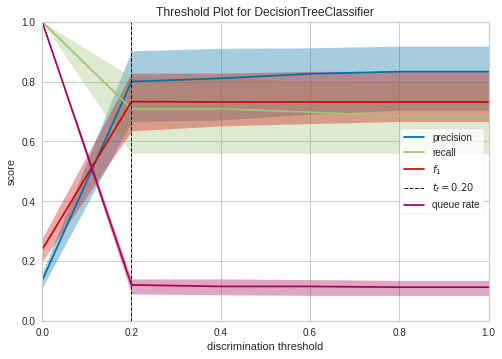

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import tree
from IPython.display import SVG, display

decision_tree = DecisionTreeClassifier(max_depth = 9, random_state = 123,
                                       splitter = "best", criterion = "gini")

telecom_churn_prediction(decision_tree, x_train, x_test, y_train, y_test, "features", threshold_plot=True)

Algorithm: KNeighborsClassifier

Classification report:
               precision    recall  f1-score   support

           0       0.85      1.00      0.92       547
           1       0.91      0.17      0.29       120

    accuracy                           0.85       667
   macro avg       0.88      0.59      0.60       667
weighted avg       0.86      0.85      0.80       667

Accuracy Score: 0.848575712143928
Area under curve: 0.5856718464351005 



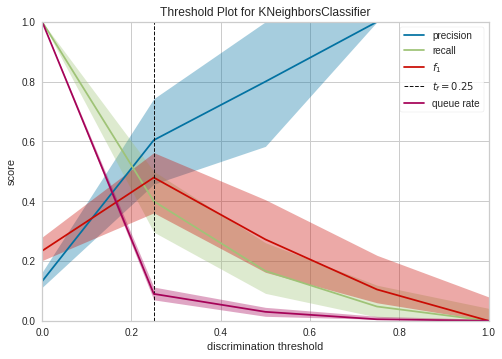

In [26]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
                           weights='uniform')
telecom_churn_prediction(knn, x_train, x_test, y_train, y_test, 'None', threshold_plot=True)

Algorithm: RandomForestClassifier

Classification report:
               precision    recall  f1-score   support

           0       0.91      0.99      0.95       547
           1       0.92      0.56      0.69       120

    accuracy                           0.91       667
   macro avg       0.91      0.77      0.82       667
weighted avg       0.91      0.91      0.90       667

Accuracy Score: 0.9115442278860569
Area under curve: 0.7736822059719684 



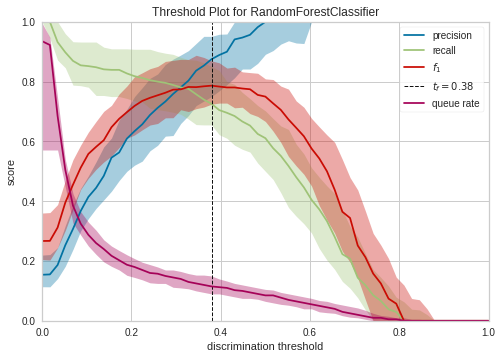

In [27]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators = 100, random_state = 123,
                             max_depth = 9, criterion = "gini")

telecom_churn_prediction(rfc, x_train, x_test, y_train, y_test, 'features', threshold_plot=True)

Algorithm: GaussianNB

Classification report:
               precision    recall  f1-score   support

           0       0.87      0.92      0.89       547
           1       0.50      0.35      0.41       120

    accuracy                           0.82       667
   macro avg       0.68      0.64      0.65       667
weighted avg       0.80      0.82      0.81       667

Accuracy Score: 0.8200899550224887
Area under curve: 0.6366087751371116 



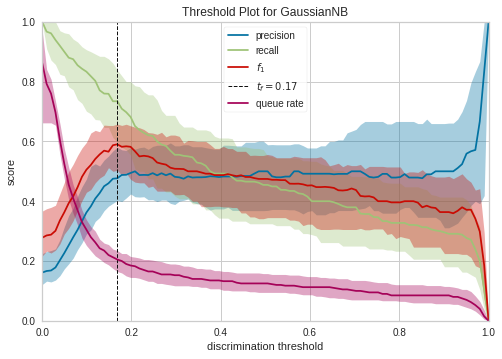

In [28]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB(priors=None)

telecom_churn_prediction(gnb, x_train, x_test, y_train, y_test, 'None', threshold_plot=True)

Algorithm: SVC

Classification report:
               precision    recall  f1-score   support

           0       0.82      1.00      0.90       547
           1       0.00      0.00      0.00       120

    accuracy                           0.82       667
   macro avg       0.41      0.50      0.45       667
weighted avg       0.67      0.82      0.74       667

Accuracy Score: 0.8200899550224887
Area under curve: 0.5 



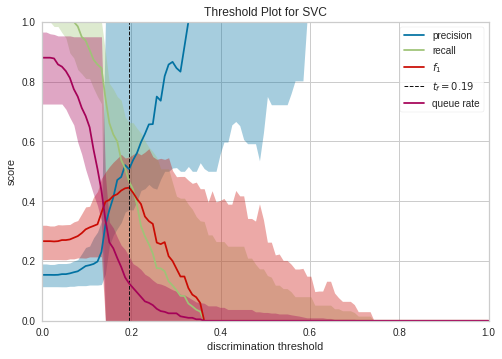

In [29]:
from sklearn.svm import SVC

#Support vector classifier using linear hyper plane
svc_lin  = SVC(C=1.0, kernel='linear', probability=True, random_state=124)

telecom_churn_prediction(svc_lin, x_train, x_test, y_train, y_test, "coefficients", threshold_plot=True)

In [ ]:
pip install xgboost

In [30]:
from xgboost import XGBClassifier

xgc = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                    colsample_bytree=1, gamma=0, learning_rate=0.9, max_delta_step=0,
                    max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
                    n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
                    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                    silent=True, subsample=1)

telecom_churn_prediction(xgc, x_train, x_test, y_train, y_test, "features", threshold_plot=True)

ModuleNotFoundError: No module named 'xgboost'

Algorithm: AdaBoostClassifier

Classification report:
               precision    recall  f1-score   support

           0       0.87      0.96      0.91       547
           1       0.66      0.32      0.43       120

    accuracy                           0.85       667
   macro avg       0.76      0.64      0.67       667
weighted avg       0.83      0.85      0.82       667

Accuracy Score: 0.8470764617691154
Area under curve: 0.6400517976843388 



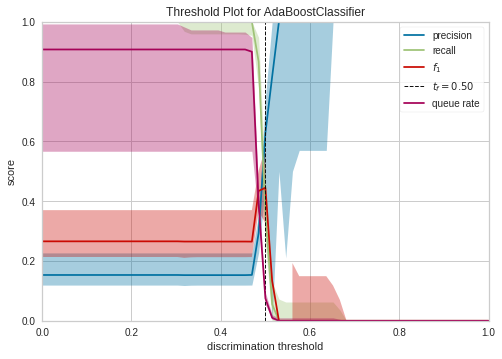

In [31]:
from sklearn.ensemble import AdaBoostClassifier

adac = AdaBoostClassifier(random_state=124)

telecom_churn_prediction(adac, x_train, x_test, y_train, y_test, "features", threshold_plot=True)


Algorithm: GradientBoostingClassifier

Classification report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96       547
           1       0.94      0.66      0.77       120

    accuracy                           0.93       667
   macro avg       0.94      0.82      0.87       667
weighted avg       0.93      0.93      0.93       667

Accuracy Score: 0.9310344827586207
Area under curve: 0.824596282754418 



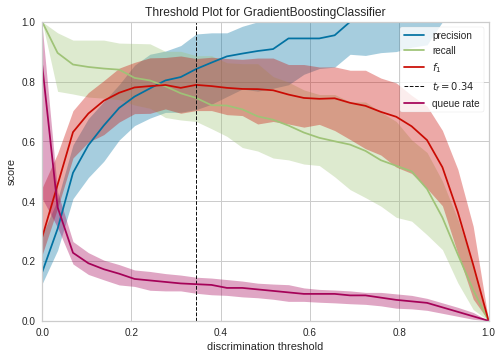

In [32]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(random_state=124)

telecom_churn_prediction(gbc, x_train, x_test, y_train, y_test, "features", threshold_plot=True)